The code was adapted from: https://www.pymc.io/projects/examples/en/latest/case_studies/BART_introduction.html

In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import rust_pgbart as pmb

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.1


/home/elantkom/.local/lib/python3.10/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/home/elantkom/.local/lib/python3.10/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(


In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Coal mining example

In [3]:
try:
    coal = np.loadtxt(Path("..", "data", "coal.csv"))
except FileNotFoundError:
    coal = np.loadtxt(pm.get_data("coal.csv"))

In [4]:
# discretize data
years = int(coal.max() - coal.min())
bins = years // 4
hist, x_edges = np.histogram(coal, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4

In [5]:
with pm.Model() as model_coal:
    μ_ = pmb.BART("μ_", X=x_data, Y=y_data, m=20)
    μ = pm.Deterministic("μ", np.abs(μ_))
    y_pred = pm.Poisson("y_pred", mu=μ, observed=y_data)
    idata_coal = pm.sample(random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


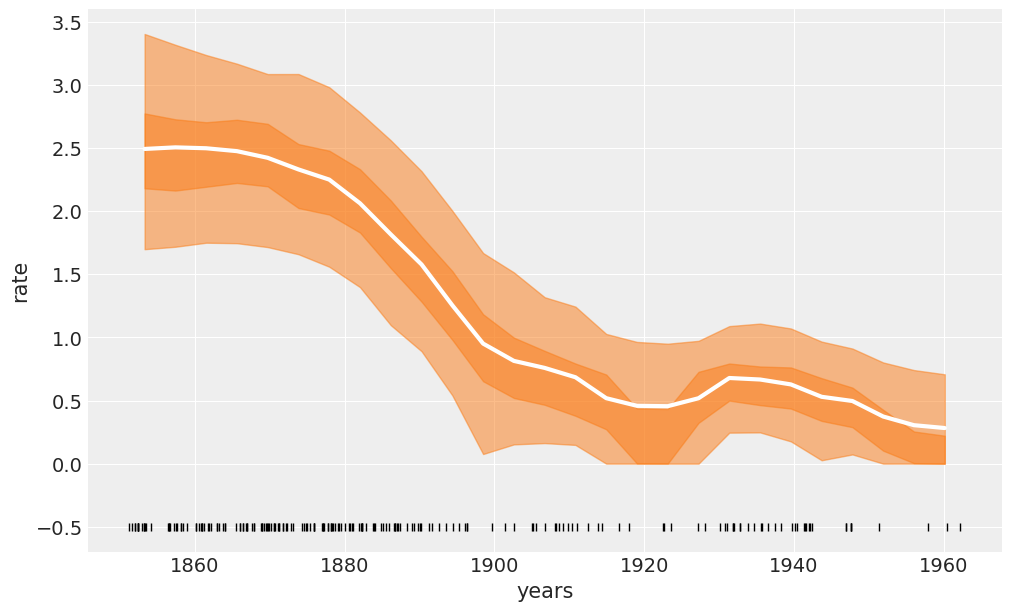

In [6]:
_, ax = plt.subplots(figsize=(10, 6))

rates = idata_coal.posterior["μ"]
rate_mean = idata_coal.posterior["μ"].mean(dim=["draw", "chain"])
ax.plot(x_centers, rate_mean, "w", lw=3)
az.plot_hdi(x_centers, rates, smooth=False)
az.plot_hdi(x_centers, rates, hdi_prob=0.5, smooth=False, plot_kwargs={"alpha": 0})
ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate");

## Bike sharing example

In [7]:
try:
    bikes = pd.read_csv(Path("..", "data", "bikes.csv"))
except FileNotFoundError:
    bikes = pd.read_csv(pm.get_data("bikes.csv"))

X = bikes[["hour", "temperature", "humidity", "workingday"]]
Y = bikes["count"]

In [8]:
with pm.Model() as model_bikes:
    σ = pm.HalfNormal("σ", Y.std())
    μ = pmb.BART("μ", X, Y, m=50)
    y = pm.Normal("y", μ, σ, observed=Y)
    idata_bikes = pm.sample(random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


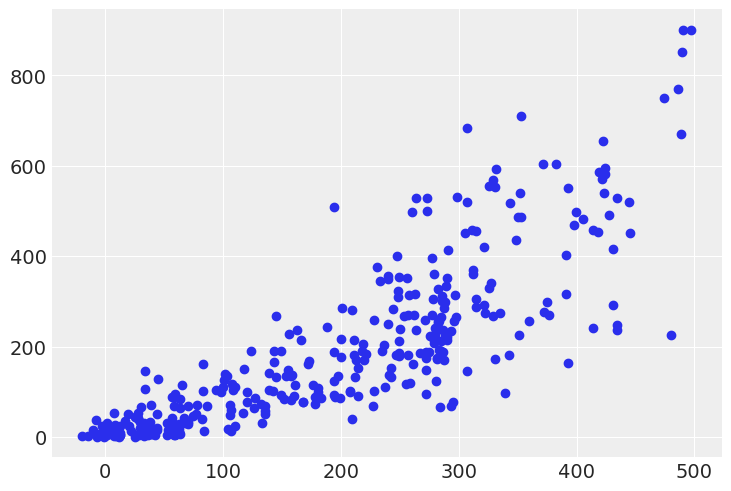

In [10]:
plt.scatter(
    idata_bikes.posterior["μ"].data.mean((0, 1)), 
    Y
)